In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Flatten, Concatenate

In [2]:
np.random.seed(123)

In [3]:
# Params
n_stores = 3
n_days = 365
store_ids = [f"Store_{i}" for i in range(n_stores)]
time_depth = 21
split_date = pd.to_datetime("2022-10-01")

In [4]:
data = []

for store in store_ids:
    base_sales = np.random.randint(80,120)
    seasonality = 10 * np.sin(np.linspace(0, 2 * np.pi, n_days))
    promo = np.random.binomial(1, 0.2, n_days)
    temp = 15 + 10 * np.sin(np.linspace(0,4 * np.pi, n_days)) + np.random.normal(0,2,n_days)
    noise = np.random.normal(0,5,n_days)
    sales = base_sales + seasonality + 5 * promo - 0.5 * temp + noise

    df_store = pd.DataFrame({
            "Date": pd.date_range("2022-01-01", periods=n_days),
            "Store_ID": store,
            "Sales" : sales,
            "Promo": promo,
            "Temperature": temp
    })

    data.append(df_store)

df = pd.concat(data).reset_index(drop=True)

In [5]:
df.sort_values(["Date","Store_ID"]).head()

,Date,Store_ID,Sales,Promo,Temperature
0,2022-01-01,Store_0,76.655651,0,16.044601
365,2022-01-01,Store_1,102.055465,1,13.943660
730,2022-01-01,Store_2,91.410729,0,13.189264
1,2022-01-02,Store_0,76.532664,0,11.331789
366,2022-01-02,Store_1,92.181945,1,9.456350


In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["Store_ID_encoded"] = le.fit_transform(df["Store_ID"])

df_train = df[df["Date"] < split_date].copy()
df_val = df[df["Date"] >= split_date].copy()

In [7]:
df.sort_values(["Date","Store_ID"]).head()

,Date,Store_ID,Sales,Promo,Temperature,Store_ID_encoded
0,2022-01-01,Store_0,76.655651,0,16.044601,0
365,2022-01-01,Store_1,102.055465,1,13.943660,1
730,2022-01-01,Store_2,91.410729,0,13.189264,2
1,2022-01-02,Store_0,76.532664,0,11.331789,0
366,2022-01-02,Store_1,92.181945,1,9.456350,1


In [8]:
def create_sequences(df, time_steps=14):
    """
    Génère des séquences temporelles à partir d’un DataFrame pour l'entraînement d’un modèle séquentiel.

    Cette fonction extrait, pour chaque magasin, des séquences glissantes de caractéristiques sur une fenêtre
    de `time_steps` jours, ainsi que la valeur cible (ventes du jour suivant). Elle encode également l'identifiant
    du magasin pour chaque séquence.

    Paramètres :
    ----------
    df : pandas.DataFrame
        DataFrame contenant les colonnes 'Store_ID', 'Store_ID_encoded', 'Date', 'Sales', 'Promo', 'Temperature'.
    time_steps : int, optionnel (par défaut = 14)
        Nombre de jours utilisés pour constituer chaque séquence.

    Retours :
    -------
    sequences : np.ndarray
        Tableau de forme (n_samples, time_steps, n_features) contenant les séquences d’entrée.
    targets : np.ndarray
        Tableau de forme (n_samples,) contenant les valeurs de ventes à prédire (target).
    store_ids : np.ndarray
        Tableau de forme (n_samples,) contenant l’identifiant encodé du magasin pour chaque séquence.
    """
    sequences = []
    targets = []
    store_ids = []

    for store_id in df["Store_ID"].unique():
        df_store = df[df["Store_ID"]==store_id].sort_values("Date")
        features = df_store[["Sales", "Promo", "Temperature"]].values
        store_encoded = df_store["Store_ID_encoded"].values[0]

        for i in range(len(features) - time_steps):
            seq = features[i:i+time_steps]
            target = features[i+time_steps][0] # Sales at t+1
            sequences.append(seq)
            targets.append(target)
            store_ids.append(store_encoded)
            
    return np.array(sequences), np.array(targets), np.array(store_ids)

X_train, y_train, store_ids_train = create_sequences(df_train,time_depth)
X_val, y_val, store_ids_val = create_sequences(df_val,time_depth)

In [14]:
X_val.shape

(213, 21, 3)

In [15]:
# # Entrées
# seq_input = Input(shape=(X_train.shape[1], X_train.shape[2])) # (21,3)
# store_input = Input(shape=(1,))

# # Embedding magasin
# store_embedding = Embedding(input_dim=n_stores, output_dim=4)(store_input)
# store_embedding_flat = Flatten()(store_embedding)

# # LSTM
# x = LSTM(64)(seq_input)

# # Fusion
# x = Concatenate()([x, store_embedding_flat])
# output = Dense(1)(x)

# model = Model(inputs=[seq_input, store_input], outputs=output)
# model.compile(optimizer="adam", loss="mse")

In [40]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model

# Entrées
seq_input = Input(shape=(X_train.shape[1], X_train.shape[2]))  # Array descriptifs(21, 3) des 21 pas 
                                                               # de temps précédents sur 3 variables
store_input = Input(shape=(1,)) # Entrée représentant l’identifiant du magasin

# Embedding magasin
store_embedding = Embedding(input_dim=n_stores, output_dim=4)(store_input) # Transforme chaque identifiant de magasin en un vecteur dense de taille 4. 
                                                                           # Cela permet au modèle d’apprendre une représentation vectorielle de chaque magasin.
store_embedding_flat = Flatten()(store_embedding)

# Bloc LSTM enrichi
x = LSTM(128, return_sequences=True)(seq_input) # return_sequences=True : 
                                                # renvoie toute la séquence de sorties (une sortie par
                                                # pas de temps), et pas seulement la dernière.
x = BatchNormalization()(x) # Normalise les activations de la couche précédente pour chaque mini-lot.
x = Dropout(0.2)(x) # régularisation qui consiste à désactiver aléatoirement 20% des neurones

x = LSTM(64)(x) # deuxième couche
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Fusion LSTM (comportement temporel) avec l'embedding magasin (comportement local)
x = Concatenate()([x, store_embedding_flat])

# Couche dense finale
output = Dense(1)(x)

# Modèle
model = Model(inputs=[seq_input, store_input], outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])


In [41]:
x

<KerasTensor shape=(None, 68), dtype=float32, sparse=False, ragged=False, name=keras_tensor_41>

In [42]:
output

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_42>

In [43]:
model

<Functional name=functional_3, built=True>

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='loss',     # Surveille la perte sur le jeu de validation
    patience=20,            # Arrête l'entraînement si aucune amélioration pendant 20 epochs
    restore_best_weights=True  # Restaure les poids du meilleur modèle
)

model.fit(
    [X_train, store_ids_train],
    y_train,
    epochs=250,
    batch_size=32,
    validation_data=([X_val, store_ids_val], y_val),
    callbacks=[early_stop]
)

Epoch 1/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 7401.3506 - mae: 85.7097 - val_loss: 6795.6455 - val_mae: 81.9703
Epoch 2/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 7321.9546 - mae: 85.2732 - val_loss: 6636.2319 - val_mae: 81.0030
Epoch 3/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 7238.4658 - mae: 84.7995 - val_loss: 6623.3857 - val_mae: 80.9574
Epoch 4/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 7120.9922 - mae: 84.1100 - val_loss: 6482.0576 - val_mae: 80.0858
Epoch 5/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6993.3623 - mae: 83.3642 - val_loss: 6447.7852 - val_mae: 79.8909
Epoch 6/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 6820.6509 - mae: 82.3228 - val_loss: 6335.0752 - val_mae: 79.1968
Epoch 7/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6634.0225 - mae: 81.1736 - val_loss: 6226.1606 - val_mae: 78.5642
Epoch 8/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6412.1367 - mae: 79.7732 - val_loss: 6128.4121 - val_mae: 

In [46]:
# model.fit([X_train, store_ids_train], y_train, epochs=250, batch_size=32)

In [47]:
y_pred = model.predict([X_val, store_ids_val])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred)

print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")


MAE : 4.71
RMSE : 36.15


In [39]:
X_val.shape

(213, 21, 3)

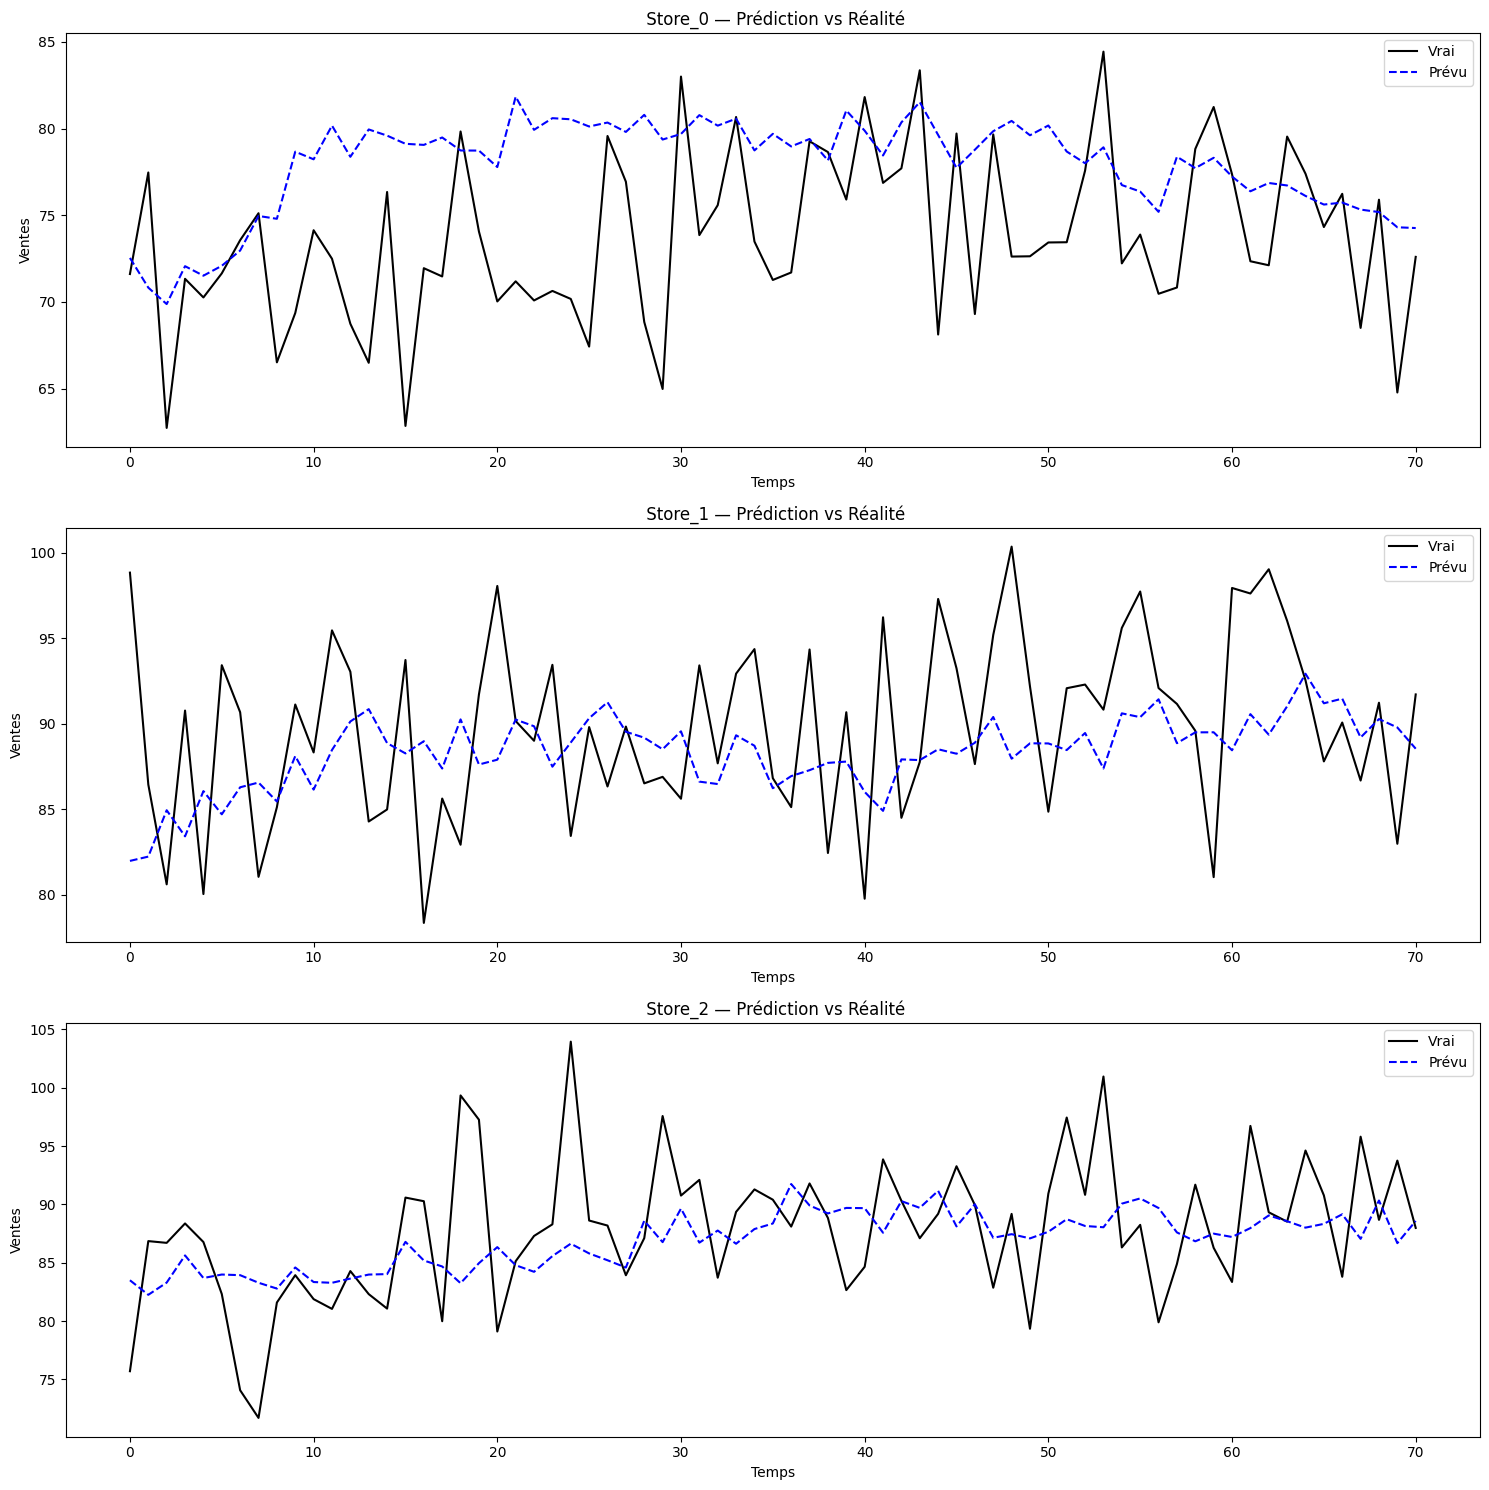

In [49]:
import matplotlib.pyplot as plt

# Récupérer les identifiants encodés
store_names = df["Store_ID"].unique()
store_encoded_map = dict(zip(le.transform(store_names), store_names))

# Tracer les courbes
plt.figure(figsize=(15, 5 * len(store_names)))

for i, store_code in enumerate(np.unique(store_ids_val)):
    # Filtrer les prédictions et vraies valeurs pour ce magasin
    idx = store_ids_val == store_code
    y_true_store = y_val[idx]
    y_pred_store = y_pred[idx].flatten()
    
    # Tracer
    plt.subplot(len(store_names), 1, i + 1)
    plt.plot(y_true_store, label="Vrai", color="black")
    plt.plot(y_pred_store, label="Prévu", color="blue", linestyle="--")
    plt.title(f" {store_encoded_map[store_code]} — Prédiction vs Réalité")
    plt.xlabel("Temps")
    plt.ylabel("Ventes")
    plt.legend()

plt.tight_layout()
plt.show()

In [46]:
# Exemple : prédire pour Store_1
store_name = "Store_1"
store_encoded = le.transform([store_name])[0]
df_store = df[df["Store_ID"] == store_name].sort_values("Date")

# Dernière séquence
last_seq = df_store[["Sales", "Promo", "Temperature"]].values[-21:]
last_seq = last_seq.reshape(1, time_depth, n_stores)
store_input = np.array([[store_encoded]])

# Prédiction
predicted_sales = model.predict([last_seq, store_input])
print(f"Prévision des ventes pour {store_name} : {predicted_sales[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Prévision des ventes pour Store_1 : 50.78
